In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
df = pd.read_excel('/project/Data/0815_page_to_label (2)_new.xlsx',encoding='utf-8',index_col=0)
df_test = pd.read_excel('/project/Data/0815_page_to_label_test_new.xlsx',encoding='utf-8',index_col=0)

In [4]:
df_predict = pd.read_excel('/project/Data/0816_page_to_label_predict.xlsx',encoding='utf-8',index_col=0)

In [5]:
df_predict.shape

(3819, 16)

In [6]:
df_predict['row'] = df_predict.index

In [7]:
df_predict['Climate'] = np.nan

In [8]:
def get_label(df1,df2,index,ori_label):
    if index in df1.index:
        return df1.loc[index,'Climate']
    elif index in df2.index:
        return df2.loc[index,'Climate']
    else:
        return ori_label
    

In [9]:
#get manual label for df and df_test
df_predict['Climate'] = df_predict.apply(lambda x: get_label(df,df_test,x.row,x.Climate),axis=1)

In [10]:
df.Climate.value_counts(True)

0.0    0.513333
0.5    0.276667
1.0    0.136667
0.1    0.073333
Name: Climate, dtype: float64

# 1. Data cleaning:
1. Remove all the url in the raw text
2. Keep only letters and numbers
3. Keep only one whitespace should there be multiple whitespaces in a row
4. Remove all the "stop phrases" which are indentified previously

In [11]:
def remove_link(text):
    type_list = [r'https://[^\s]+','http://[^\s]+',r'www\.[^\s]+',
                 r'[^\s]+\.html','[^\s]+@[^\s]+','[^\s]+\.com[^\s]+']
    for t in type_list:
        text = re.sub(t,'',text)
    return text

In [12]:
df['clean_text'] = df.raw_text.apply(remove_link)
df_test['clean_text'] = df_test.raw_text.apply(remove_link)
df_predict['clean_text'] = df_predict.raw_text.apply(remove_link)

In [13]:
def clean_text(text):
    text = re.sub(r'[^A-Za-z0-9 ]',' ',text)
    text = re.sub(r' {2,}',' ',text)
    return text

In [20]:
df['clean_text'] = df.clean_text.apply(clean_text)
df_test['clean_text'] = df_test.clean_text.apply(clean_text)
df_predict['clean_text'] = df_predict.clean_text.apply(clean_text)

In [21]:
stop_phrase = ['economic environment','operating environment',
               'geopolitical environment','control environment',
               'interest rate environment','changing environment',
               'rate environment','technology environment'
               'risk environment','external environment',
               'internal environment','commercial environment ',
               'market environment','business environment',
               'regulatory environment','legal environment',
               'macro environment','regulated environment','competitive environment',
               'sustainable value for shareholders','sustainable return',
               'sustainable dividend', 'sustainable cash flow'
               'sustainable capital strength',
               'climate of low interest rates',
              ]
remove_string = r'|'.join(stop_phrase)

In [22]:
df['clean_text_lower'] = df.clean_text.apply(lambda x: re.sub(remove_string,' ',x.lower()))
df_test['clean_text_lower'] = df_test.clean_text.apply(lambda x: re.sub(remove_string,' ',x.lower()))
df_predict['clean_text_lower'] = df_predict.clean_text.apply(lambda x: re.sub(remove_string,' ',x.lower()))

# 2. Data Engineering and data preparation
1. Relabel labelled data
2. split data into train and validation set
3. Numerical/Heuristic Features: absolute/ relative keyword frequency,Annual report indicator,page length (all standardised)
4. Tokenisation and lemmatisation
5. Bag-of-Words representation
6. TFIDF representation
7. Resample training data

In [23]:
label_dict = {0:0,0.1:0,0.5:1,1:1}
df['Climate_label'] = df.Climate.map(label_dict)
df_test['Climate_label'] = df_test.Climate.map(label_dict)
df_predict['Climate_label'] = df_predict.Climate.map(label_dict)

In [24]:
#train and valid split
from sklearn.model_selection import train_test_split
df_train, df_val = train_test_split(df, test_size=0.2,stratify=df['Climate_label'], shuffle=True, random_state=42)

In [25]:
climate_keywords = ['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green']
search_string = r'|'.join(climate_keywords)

In [26]:
for kw in climate_keywords:
    df_train[kw] = df_train.clean_text_lower.apply(lambda x: len(re.findall(kw,x)))
    df_val[kw] = df_val.clean_text_lower.apply(lambda x: len(re.findall(kw,x)))
    df_test[kw] = df_test.clean_text_lower.apply(lambda x: len(re.findall(kw,x)))
    df_predict[kw] = df_predict.clean_text_lower.apply(lambda x: len(re.findall(kw,x)))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [27]:
df_train['page_len'] = df_train.clean_text_lower.apply(lambda x: len(x))
df_val['page_len'] = df_val.clean_text_lower.apply(lambda x: len(x))
df_test['page_len'] = df_test.clean_text_lower.apply(lambda x: len(x))
df_predict['page_len'] = df_predict.clean_text_lower.apply(lambda x: len(x))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [28]:
for kw in climate_keywords:
    df_train[kw+'_ratio'] = df_train.loc[:,kw].values/df_train.loc[:,'page_len'].values
    df_val[kw+'_ratio'] = df_val.loc[:,kw].values/df_val.loc[:,'page_len'].values
    df_test[kw+'_ratio'] = df_test.loc[:,kw].values/df_test.loc[:,'page_len'].values
    df_predict[kw+'_ratio'] = df_predict.loc[:,kw].values/df_predict.loc[:,'page_len'].values

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [29]:
df_train['Annual'] = df_train.report_type.apply(lambda x: 1 if x=='Annual' else 0)
df_val['Annual'] = df_val.report_type.apply(lambda x: 1 if x=='Annual' else 0)
df_test['Annual'] = df_test.report_type.apply(lambda x: 1 if x=='Annual' else 0)
df_predict['Annual'] = df_predict.report_type.apply(lambda x: 1 if x=='Annual' else 0)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [30]:
df.Climate_label.value_counts()

0    176
1    124
Name: Climate_label, dtype: int64

In [31]:
df_val.Climate_label.value_counts()

0    35
1    25
Name: Climate_label, dtype: int64

In [32]:
df_test.Climate_label.value_counts()

0    73
1    27
Name: Climate_label, dtype: int64

In [33]:
import spacy
import re
from joblib import Parallel, delayed
from wordsegment import load, segment #to_split words
load()

In [34]:
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    import spacy.cli 
    print("Model not found. Downloading.")
    spacy.cli.download("en_core_web_md")
    import en_core_web_md
    nlp = en_core_web_md.load()
    
nlp = spacy.load('en_core_web_md', disable=['tagger', 'parser', 'ner'])

In [35]:
all_stopwords = nlp.Defaults.stop_words

In [36]:
# joblib pipeline
def lemmatize_pipe(doc):
    lemma_list = [str(tok.lemma_).lower() for tok in doc
                  if tok.text.lower() not in all_stopwords]
#     token_list = [token.text for token in doc]
    #print(token_list)
#     segemented = ' '.join([' '.join(segment(i)) for i in token_list]).strip()
#     lemma_list = [str(tok.lemma_).lower() for tok in nlp(segemented)
#                   if tok.text.lower() not in all_stopwords]

    return lemma_list

def preprocess_pipe(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe
def chunker(iterable, total_length, chunksize):
    return (iterable[pos: pos + chunksize] for pos in range(0, total_length, chunksize))

def flatten(list_of_lists):
    "Flatten a list of lists to a combined list"
    return [item for sublist in list_of_lists for item in sublist]

def process_chunk(texts):
    preproc_pipe = []
    for doc in nlp.pipe(texts, batch_size=20):
        preproc_pipe.append(lemmatize_pipe(doc))
    return preproc_pipe

def preprocess_parallel(texts, chunksize=100):
    executor = Parallel(n_jobs=7, backend='multiprocessing', prefer="processes")
    do = delayed(process_chunk) # the operation piece
    tasks = (do(chunk) for chunk in chunker(texts, len(texts), chunksize=chunksize))
    result = executor(tasks)
    return flatten(result)

In [37]:
#Tokenization
df_train['tokens'] = preprocess_parallel(df_train['clean_text'], chunksize=100)
df_val['tokens'] = preprocess_parallel(df_val['clean_text'], chunksize=100)
df_test['tokens'] = preprocess_parallel(df_test['clean_text'], chunksize=100)
df_predict['tokens'] = preprocess_parallel(df_predict['clean_text'], chunksize=100)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [38]:
df_train['clean_token_str'] = df_train.tokens.apply(lambda x: ' '.join(x))
df_val['clean_token_str'] = df_val.tokens.apply(lambda x: ' '.join(x))
df_test['clean_token_str'] = df_test.tokens.apply(lambda x: ' '.join(x))
df_predict['clean_token_str'] = df_predict.tokens.apply(lambda x: ' '.join(x))

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [39]:
df_model_result = pd.DataFrame(columns=['Model Name','Representation(Features)',
                                       'Training Accuracy','Validation Accuracy',
                                        'Dimensionality'])

In [40]:
y_train = df_train['Climate_label']
y_val = df_val['Climate_label']
y_test = df_test['Climate_label']

In [41]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(df_train['clean_token_str']).toarray()
X_val_bow = vectorizer.transform(df_val['clean_token_str']).toarray()
X_test_bow = vectorizer.transform(df_test['clean_token_str']).toarray()
X_predict_bow = vectorizer.transform(df_predict['clean_token_str']).toarray()

In [42]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_train_tfidf = tfidfconverter.fit_transform(X_train_bow).toarray()
X_val_tfidf = tfidfconverter.transform(X_val_bow).toarray()
X_test_tfidf = tfidfconverter.transform(X_test_bow).toarray()
X_predict_tfidf = tfidfconverter.transform(X_predict_bow).toarray()

In [43]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_kw = scaler.fit_transform(df_train.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])
X_val_kw = scaler.transform(df_val.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])
X_test_kw = scaler.transform(df_test.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])
# X_predict_kw = scaler.transform(df_predict.loc[:,['biodiversity','carbon','climate','ecology',
#                'environment','emission','pollution','sustainable',
#               'environmental','esg','tcfd','sustainability','green',
#                'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
#                'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
#               'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])

# 3. Modeling with Full Futures
1. Linear SVM
2. Random forest
3. XGboost

In [44]:
from imblearn.over_sampling import SMOTE
X_train_bow_resampled, y_train_bow_resampled = SMOTE(random_state=0).fit_resample(X_train_bow,y_train)
X_train_tfidf_resampled, y_train_tfidf_resampled = SMOTE(random_state=0).fit_resample(X_train_tfidf,y_train)
X_train_kw_resampled, y_train_kw_resampled = SMOTE(random_state=0).fit_resample(X_train_kw,y_train)

In [45]:
X_train_bow_resampled.shape

(282, 6884)

In [46]:
X_train_tfidf_resampled.shape

(282, 6884)

In [47]:
X_train_kw_resampled.shape

(282, 28)

In [48]:
y_train_bow_resampled.value_counts()

1    141
0    141
Name: Climate_label, dtype: int64

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,accuracy_score

In [50]:
# linear SVM
from sklearn.svm import LinearSVC
svc = LinearSVC()
#bow
svc.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = svc.predict(X_train_bow_resampled)
y_val_bow_pre = svc.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'LinearSVC',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Original'},ignore_index=True)
#tfidf
svc.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = svc.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = svc.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'LinearSVC',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

#kw
svc.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = svc.predict(X_train_kw_resampled)
y_val_kw_pre = svc.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
df_model_result = df_model_result.append({'Model Name':'LinearSVC',
           'Representation(Features)':'Keyword',
           'Training Accuracy':kw_train_sc ,
           'Validation Accuracy':kw_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

In [51]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

#bow
rf.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = rf.predict(X_train_bow_resampled)
y_val_bow_pre = rf.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Original'},ignore_index=True)
#tfidf
rf.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = rf.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = rf.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

#kw
rf.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = rf.predict(X_train_kw_resampled)
y_val_kw_pre = rf.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
           'Representation(Features)':'Keyword',
           'Training Accuracy':kw_train_sc ,
           'Validation Accuracy':kw_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

In [52]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

#bow
xgb.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = xgb.predict(X_train_bow_resampled)
y_val_bow_pre = xgb.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Original'},ignore_index=True)
#tfidf
xgb.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = xgb.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = xgb.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

#kw
xgb.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = xgb.predict(X_train_kw_resampled)
y_val_kw_pre = xgb.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
           'Representation(Features)':'Keyword',
           'Training Accuracy':kw_train_sc ,
           'Validation Accuracy':kw_val_sc,
            'Dimensionality':'Original'},ignore_index=True)

# 4. Dimensionality Reduction

In [53]:
#  truncated SVD(LSA)
from sklearn.decomposition import TruncatedSVD
n = 240
svd = TruncatedSVD(n_components=n, n_iter=5, random_state=0)
svd.fit(X_train_bow)


TruncatedSVD(n_components=240, random_state=0)

154


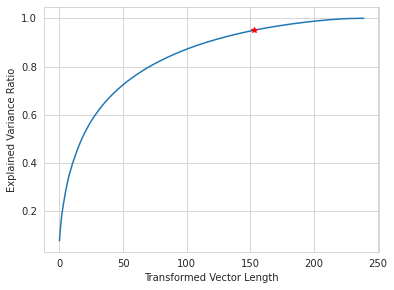

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid") 
%matplotlib inline
plt.figure(figsize=(4*1.5,3+1.5))
y = np.cumsum(svd.explained_variance_ratio_)
x = list(range(n))
sns.lineplot(x,y)
components = np.argmax(y>=0.95)+1
plt.xlabel('Transformed Vector Length')
plt.ylabel('Explained Variance Ratio')
#plt.title('SVD Components Explained Variance Ratio for Bag-of-Words Representation')
plt.plot(x[components-1], y[components-1], 'r*')
print(components)
plt.show()

In [55]:
n = 240
svd2 = TruncatedSVD(n_components=n, n_iter=5, random_state=0)
svd2.fit(X_train_tfidf)

TruncatedSVD(n_components=240, random_state=0)

200


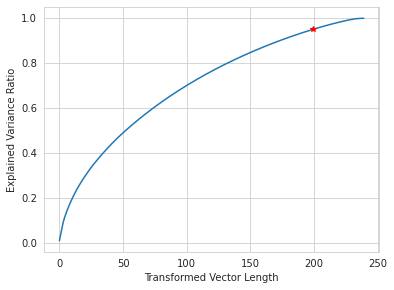

In [56]:
plt.figure(figsize=(4*1.5,3+1.5))
y = np.cumsum(svd2.explained_variance_ratio_)
x = list(range(n))
sns.lineplot(x,y)
components = np.argmax(y>=0.95)+1
plt.xlabel('Transformed Vector Length')
plt.ylabel('Explained Variance Ratio')
#plt.title('SVD Components Explained Variance Ratio for TFIDF Representation')
plt.plot(x[components-1], y[components-1], 'r*')
print(components)
plt.show()

In [59]:
# Dimensionality reduction
svd = TruncatedSVD(n_components=154, n_iter=5, random_state=0)
X_train_bow = svd.fit_transform(X_train_bow )
X_val_bow = svd.transform(X_val_bow)
X_test_bow = svd.transform(X_test_bow)

svd2 = TruncatedSVD(n_components=200, n_iter=5, random_state=0)
X_train_tfidf = svd2.fit_transform(X_train_tfidf)
X_val_tfidf = svd2.transform(X_val_tfidf)
X_test_tfidf = svd2.transform(X_test_tfidf)


In [60]:
from imblearn.over_sampling import SMOTE
X_train_bow_resampled, y_train_bow_resampled = SMOTE(random_state=0).fit_resample(X_train_bow,y_train)
X_train_tfidf_resampled, y_train_tfidf_resampled = SMOTE(random_state=0).fit_resample(X_train_tfidf,y_train)
X_train_kw_resampled, y_train_kw_resampled = SMOTE(random_state=0).fit_resample(X_train_kw,y_train)

# 5. Modeling with Reduced Features
1. Linear SVM
2. Random forest
3. XGboost

In [61]:
# linear SVM
from sklearn.svm import LinearSVC
svc = LinearSVC()
#bow
svc.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = svc.predict(X_train_bow_resampled)
y_val_bow_pre = svc.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'LinearSVC',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)
#tfidf
svc.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = svc.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = svc.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'LinearSVC',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)

#kw
svc.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = svc.predict(X_train_kw_resampled)
y_val_kw_pre = svc.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
# df_model_result = df_model_result.append({'Model Name':'LinearSVC',
#            'Representation(Features)':'Keyword',
#            'Training Accuracy':kw_train_sc ,
#            'Validation Accuracy':kw_val_sc,
#             'Dimensionality':'Reduced'},ignore_index=True)

/opt/anaconda/envs/Python3/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [62]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

#bow
rf.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = rf.predict(X_train_bow_resampled)
y_val_bow_pre = rf.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)
#tfidf
rf.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = rf.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = rf.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)

#kw
rf.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = rf.predict(X_train_kw_resampled)
y_val_kw_pre = rf.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
# df_model_result = df_model_result.append({'Model Name':'RandomForestClassifier',
#            'Representation(Features)':'Keyword',
#            'Training Accuracy':kw_train_sc ,
#            'Validation Accuracy':kw_val_sc,
#             'Dimensionality':'Reduced'},ignore_index=True)

In [63]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

#bow
xgb.fit(X_train_bow_resampled, y_train_bow_resampled)
y_train_bow_resampled_pre = xgb.predict(X_train_bow_resampled)
y_val_bow_pre = xgb.predict(X_val_bow)
bow_train_sc = accuracy_score(y_train_bow_resampled,y_train_bow_resampled_pre)
bow_val_sc = accuracy_score(y_val,y_val_bow_pre)
df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
           'Representation(Features)':'Bag-of-Words',
           'Training Accuracy':bow_train_sc,
           'Validation Accuracy':bow_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)
#tfidf
xgb.fit(X_train_tfidf_resampled, y_train_tfidf_resampled)
y_train_tfidf_resampled_pre = xgb.predict(X_train_tfidf_resampled)
y_val_tfidf_pre = xgb.predict(X_val_tfidf)
tfidf_train_sc = accuracy_score(y_train_tfidf_resampled,y_train_tfidf_resampled_pre)
tfidf_val_sc = accuracy_score(y_val,y_val_tfidf_pre)
df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
           'Representation(Features)':'TFIDF',
           'Training Accuracy':tfidf_train_sc ,
           'Validation Accuracy':tfidf_val_sc,
            'Dimensionality':'Reduced'},ignore_index=True)

#kw
xgb.fit(X_train_kw_resampled, y_train_kw_resampled)
y_train_kw_resampled_pre = xgb.predict(X_train_kw_resampled)
y_val_kw_pre = xgb.predict(X_val_kw)
kw_train_sc = accuracy_score(y_train_kw_resampled,y_train_kw_resampled_pre)
kw_val_sc = accuracy_score(y_val,y_val_kw_pre)
# df_model_result = df_model_result.append({'Model Name':'XGBClassifier',
#            'Representation(Features)':'Keyword',
#            'Training Accuracy':kw_train_sc ,
#            'Validation Accuracy':kw_val_sc,
#             'Dimensionality':'Reduced'},ignore_index=True)

In [306]:
# Keyword and Random forest

In [55]:
#df_model_result # 0820 original result

,Model Name,Representation(Features),Training Accuracy,Validation Accuracy,Dimensionality,Dimentionality
0,LinearSVC,Bag-of-Words,1.000000,0.750000,NaN,Original
1,LinearSVC,TFIDF,1.000000,0.783333,Original,NaN
2,LinearSVC,Keyword,0.950355,0.916667,Original,NaN
3,RandomForestClassifier,Bag-of-Words,1.000000,0.716667,NaN,Original
4,RandomForestClassifier,TFIDF,1.000000,0.766667,Original,NaN
5,RandomForestClassifier,Keyword,1.000000,0.933333,Original,NaN
6,XGBClassifier,Bag-of-Words,1.000000,0.833333,NaN,Original
7,XGBClassifier,TFIDF,1.000000,0.800000,Original,NaN
8,XGBClassifier,Keyword,0.996454,0.916667,Original,NaN
9,LinearSVC,Bag-of-Words,1.000000,0.800000,NaN,Reduced


# 6. Test (Random Forest with Keyword)

In [71]:
X_train_kw = scaler.transform(df_train.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])
X_test_kw = scaler.transform(df_test.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])

In [72]:
X_train_kw_resampled, y_train_kw_resampled = SMOTE(random_state=0).fit_resample(X_train_kw,y_train)

In [73]:
X_test_kw.shape

(100, 28)

In [74]:
rf = RandomForestClassifier()

#bow
rf.fit(X_train_kw_resampled, y_train_kw_resampled)
y_test_kw_pre = rf.predict(X_test_kw)

In [75]:
print(classification_report(y_test, y_test_kw_pre))
accuracy_score(y_test, y_test_kw_pre)

              precision    recall  f1-score   support

           0       0.96      0.97      0.97        73
           1       0.92      0.89      0.91        27

    accuracy                           0.95       100
   macro avg       0.94      0.93      0.94       100
weighted avg       0.95      0.95      0.95       100



0.95

In [91]:
# save the model
# import pickle
# pkl_filename = "/project/model/page_classification_rf_0819.pkl"
# with open(pkl_filename, 'wb') as file:
#     pickle.dump(rf, file)

In [92]:
# # Load from file
# with open("/project/model/page_classification_rf_0819.pkl", 'rb') as file:
#     pickle_model = pickle.load(file)

In [76]:
y_test.value_counts()

0    73
1    27
Name: Climate_label, dtype: int64

In [78]:
fail_index = (y_test!= y_test_kw_pre)

In [79]:
df_test.loc[fail_index,'Climate']

4266    0.5
48      0.0
1692    0.5
1191    0.5
1970    0.0
Name: Climate, dtype: float64

# 7. Get Prediction for Unlabelled Data

In [80]:
X_predict_kw = scaler.transform(df_predict.loc[:,['biodiversity','carbon','climate','ecology',
               'environment','emission','pollution','sustainable',
              'environmental','esg','tcfd','sustainability','green',
               'page_len','Annual','biodiversity_ratio','carbon_ratio','climate_ratio','ecology_ratio',
               'environment_ratio','emission_ratio','pollution_ratio','sustainable_ratio',
              'environmental_ratio','esg_ratio','tcfd_ratio','sustainability_ratio','green_ratio']])

In [81]:
y_predict_pre = rf.predict(X_predict_kw)
df_predict['Climate'] = y_predict_pre 

In [83]:
#replace predicted label manual label from df and df_test 
df_predict['Climate'] = df_predict.apply(lambda x: get_label(df,df_test,x.row,x.Climate),axis=1)

In [82]:
#get manual label for df and df_test
df_predict['Climate'].value_counts()

0    2851
1     968
Name: Climate, dtype: int64

In [87]:
label_dict = {0:0,0.1:0,0.5:1,1:1}
df_predict['Climate'] = df_predict.Climate.map(label_dict)

In [88]:
#final labels
df_predict['Climate'].value_counts()

0    2846
1     973
Name: Climate, dtype: int64

In [94]:
# df_predict.to_excel('/project/Data/kw_predict_page_new.xlsx',encoding='utf-8')